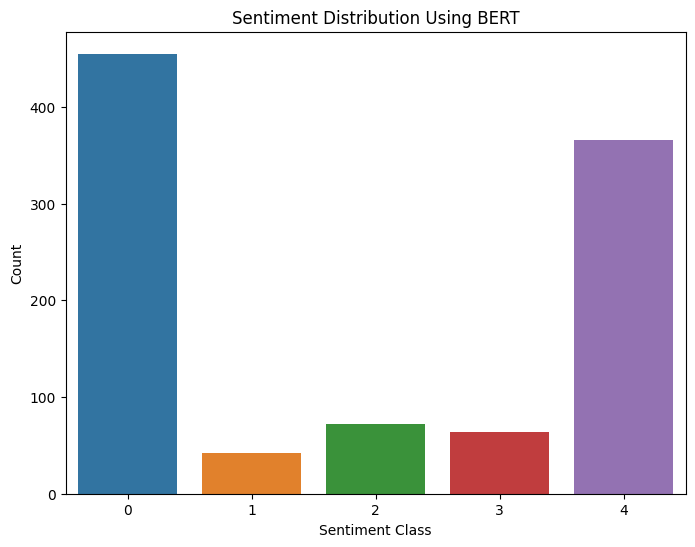

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader
from transformers import pipeline
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset

df_val = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv')

# 1. Data Preprocessing - Clean the text data
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text


df_val['cleaned_text'] = df_val['I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣'].apply(clean_text)

# 2. Load Pre-trained BERT model and Tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"  # BERT model for sentiment analysis
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# 3. Define a Sentiment Analysis Function Using BERT
def get_bert_sentiment(text):
    # Encode the text (convert it into tokens)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    # Get model output
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the predicted class label (logits)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()
    return predicted_class

# 4. Apply BERT-based Sentiment Analysis on the cleaned text
df_val['bert_sentiment'] = df_val['cleaned_text'].apply(get_bert_sentiment)

# 5. Visualize the sentiment distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='bert_sentiment', data=df_val)
plt.title('Sentiment Distribution Using BERT')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')
plt.show()

# 6. Map sentiment classes to labels if needed
sentiment_labels = {0: 'very negative', 1: 'negative', 2: 'neutral', 3: 'positive', 4: 'very positive'}
df_val['sentiment_label'] = df_val['bert_sentiment'].map(sentiment_labels)




In [6]:
pip install gensim nltk scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 36.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tsfresh 0.20.3 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import nltk
from nltk.corpus import stopwords
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
import re

# Download NLTK stopwords
nltk.download('stopwords')
nltk.download('punkt')

# Define a function to preprocess text for LDA
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stopwords
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

# Apply preprocessing to the cleaned text
df_val['tokens'] = df_val['cleaned_text'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
# Create a dictionary and corpus
dictionary = Dictionary(df_val['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in df_val['tokens']]


In [18]:
# Set the number of topics
num_topics = 5

# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)

# Print the topics with top words
topics = lda_model.print_topics(num_words=10)
for topic_num, topic_words in topics:
    
    print(f"Topic {topic_num + 1}: {topic_words}")


Topic 1: 0.013*"game" + 0.007*"people" + 0.007*"like" + 0.006*"im" + 0.005*"really" + 0.005*"fucking" + 0.004*"na" + 0.004*"good" + 0.004*"best" + 0.004*"league"
Topic 2: 0.007*"im" + 0.006*"playing" + 0.006*"red" + 0.006*"love" + 0.006*"dead" + 0.006*"dont" + 0.006*"redemption" + 0.005*"much" + 0.005*"play" + 0.005*"like"
Topic 3: 0.011*"game" + 0.009*"like" + 0.008*"im" + 0.006*"dead" + 0.005*"one" + 0.005*"redemption" + 0.005*"red" + 0.005*"fuck" + 0.005*"get" + 0.005*"good"
Topic 4: 0.007*"get" + 0.006*"johnson" + 0.005*"game" + 0.005*"fifa" + 0.005*"one" + 0.005*"best" + 0.005*"cant" + 0.005*"new" + 0.005*"love" + 0.004*"black"
Topic 5: 0.016*"johnson" + 0.005*"im" + 0.005*"got" + 0.005*"fucking" + 0.005*"game" + 0.004*"love" + 0.004*"google" + 0.004*"get" + 0.004*"first" + 0.003*"baby"


In [10]:
# Compute coherence score
coherence_model = CoherenceModel(model=lda_model, texts=df_val['tokens'], dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
print(f"Coherence Score: {coherence_score}")


Coherence Score: 0.328198627214524


In [11]:
# Function to find the dominant topic for a document
def get_dominant_topic(doc_bow):
    topic_probs = lda_model.get_document_topics(doc_bow)
    dominant_topic = max(topic_probs, key=lambda x: x[1])[0]  # Topic with highest probability
    return dominant_topic

# Add dominant topics to the DataFrame
df_val['dominant_topic'] = [get_dominant_topic(doc) for doc in corpus]


In [12]:
pip install pyLDAvis


Note: you may need to restart the kernel to use updated packages.


In [13]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Prepare the visualization
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(lda_vis)


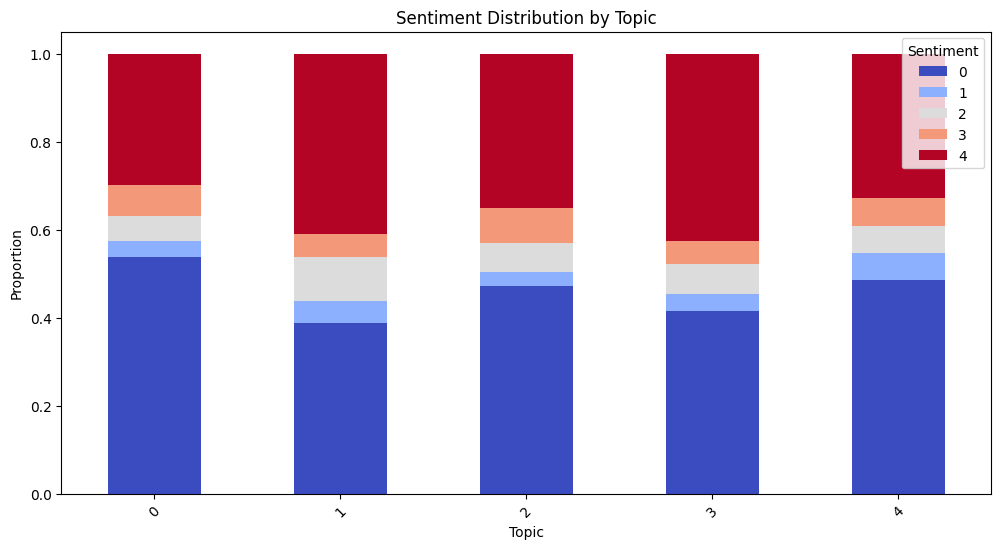

In [14]:
# Analyze sentiment distribution within each topic
topic_sentiment = df_val.groupby('dominant_topic')['bert_sentiment'].value_counts(normalize=True).unstack()
topic_sentiment.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title('Sentiment Distribution by Topic')
plt.xlabel('Topic')
plt.ylabel('Proportion')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.show()
